In [ ]:
import cv2
import random
import os
import keras
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
    Dropout,
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install nb_black

  Using cached nb_black-1.0.7.tar.gz (4.8 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 144
IMAGE_HEIGHT = 144
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "/content/drive/MyDrive/hhtqd/dataset/train/"

# Dictionary to save our 12 classes
categories = {
    0: "000000",
    1: "000200",
    2: "000500",
    3: "001000",
    4: "002000",
    5: "005000",
    6: "010000",
    7: "020000",
    8: "050000",
    9: "100000",
    10: "200000",
    11: "500000",
}

In [ ]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(
        lambda x: x[: re.search("_", x).start()] + "/" + x
    )
    return df


# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({"filename": filenames_list, "category": categories_list})
df = add_class_name_prefix(df, "filename")

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print("number of elements = ", len(df))
df

number of elements =  2712


,filename,category
0,000200/000200_32.png,1
1,002000/002000_65.png,4
2,001000/001000_150.png,3
3,002000/002000_172.png,4
4,200000/200000_30.png,10
...,...,...
2707,002000/002000_145.png,4
2708,020000/020000_168.png,7
2709,100000/100000_32.png,9
2710,000200/000200_201.png,1


001000/001000_77.png


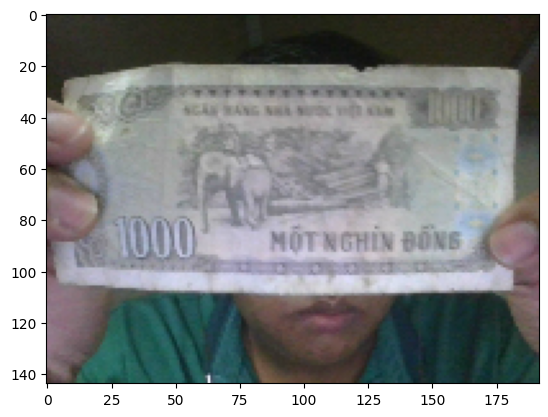

In [ ]:
random_row = random.randint(0, len(df) - 1)
sample = df.iloc[random_row]
randomimage = keras.utils.load_img(base_path + sample["filename"])
print(sample["filename"])
plt.imshow(randomimage)

Text(0.5, 1.02, 'Count of images per class')

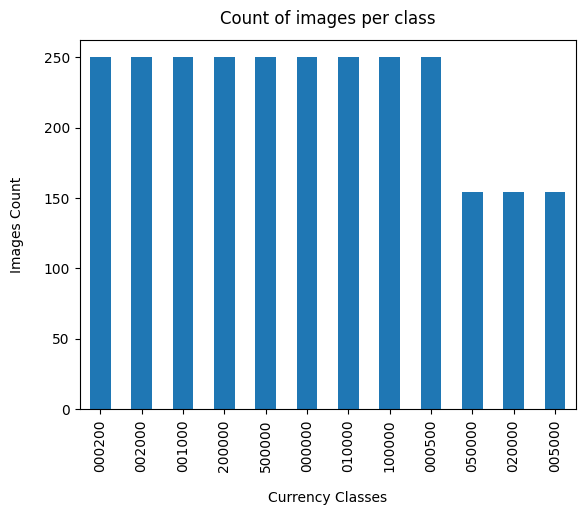

In [ ]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization["category"] = df_visualization["category"].apply(
    lambda x: categories[x]
)

df_visualization["category"].value_counts().plot.bar(x="count", y="category")

plt.xlabel("Currency Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02)

In [ ]:
# Change the categories from numbers to names
df["category"] = df["category"].replace(categories)

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.25, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
total_test = test_df.shape[0]
print(
    "train size = ",
    total_train,
    "validate size = ",
    total_validate,
    "test size = ",
    test_df.shape[0],
)

train size =  2034 validate size =  339 test size =  339


In [ ]:
batch_size = 32

datagen = image.ImageDataGenerator(
    ###  Augmentation Start  ###
    #     rescale=1.0
    #     / 255
    # rotation_range=30,
    # shear_range=0.1,
    # zoom_range=0.3,
    # horizontal_flip=True,
    # vertical_flip = True,
    # width_shift_range=0.2,
    # height_shift_range=0.2
    ##  Augmentation End  ###
)

train_generator = datagen.flow_from_dataframe(
    train_df,
    base_path,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size,
)

validation_generator = datagen.flow_from_dataframe(
    validate_df,
    base_path,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size,
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    base_path,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
)

Found 2034 validated image filenames belonging to 12 classes.
Found 339 validated image filenames belonging to 12 classes.
Found 339 validated image filenames belonging to 12 classes.


In [ ]:
model = Sequential()
model.add(
    Conv2D(
        filters=64,
        kernel_size=3,
        activation="relu",
        padding="same",
        input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    )
)
# model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# model.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# model.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# model.add(Conv2D(filters=1024, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(filters=1024, kernel_size=3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dense(4096, activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(4096, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 144, 144, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 144, 144, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 72, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 128)       512       
 chNormalization)                                                
                                                        

In [ ]:
EPOCHS = 20
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=2, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=[learning_rate_reduction, early_stop],
)

Epoch 1/20
63/63 [==============================] - 823s 13s/step - loss: 2.4311 - accuracy: 0.4630 - val_loss: 14.8559 - val_accuracy: 0.1656 - lr: 0.0010
Epoch 2/20
63/63 [==============================] - 737s 12s/step - loss: 1.0816 - accuracy: 0.7093 - val_loss: 7.7210 - val_accuracy: 0.3875 - lr: 0.0010
Epoch 3/20
63/63 [==============================] - 714s 11s/step - loss: 0.7281 - accuracy: 0.8007 - val_loss: 4.5436 - val_accuracy: 0.5031 - lr: 0.0010
Epoch 4/20
63/63 [==============================] - 721s 11s/step - loss: 0.4767 - accuracy: 0.8576 - val_loss: 5.5227 - val_accuracy: 0.4156 - lr: 0.0010
Epoch 5/20
63/63 [==============================] - ETA: 0s - loss: 0.4394 - accuracy: 0.8781 
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
63/63 [==============================] - 706s 11s/step - loss: 0.4394 - accuracy: 0.8781 - val_loss: 8.5883 - val_accuracy: 0.2937 - lr: 0.0010
Epoch 6/20
63/63 [==============================] - 719s 11s/ste

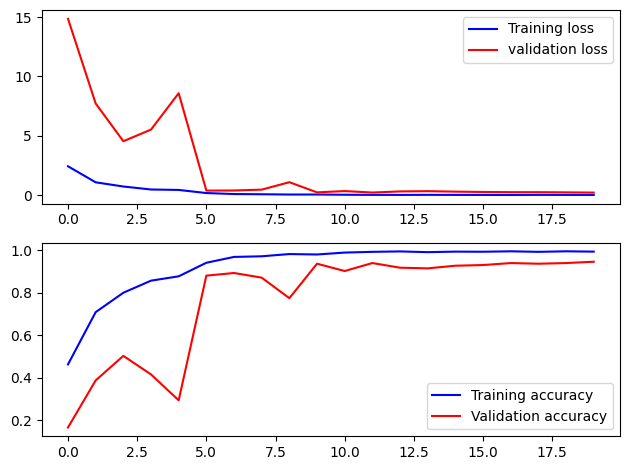

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history["loss"], color="b", label="Training loss")
ax1.plot(history.history["val_loss"], color="r", label="validation loss")
ax1.legend()

ax2.plot(history.history["accuracy"], color="b", label="Training accuracy")
ax2.plot(history.history["val_accuracy"], color="r", label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)
print("Accuracy on test set = ", round((accuracy * 100), 2), "% ")

<ipython-input-26-3bec3a93550b>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


Accuracy on test set =  91.74 % 


In [ ]:
gen_label_map = test_generator.class_indices
gen_label_map = dict((v, k) for k, v in gen_label_map.items())
print(gen_label_map)

{0: '000000', 1: '000200', 2: '000500', 3: '001000', 4: '002000', 5: '005000', 6: '010000', 7: '020000', 8: '050000', 9: '100000', 10: '200000', 11: '500000'}


In [ ]:
# get the model's predictions for the test set
preds = model.predict_generator(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df["category"].to_numpy()

print(classification_report(labels, preds))

<ipython-input-28-2f91699b1d85>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, nb_samples)


              precision    recall  f1-score   support

      000000       0.97      0.97      0.97        37
      000200       0.76      1.00      0.87        29
      000500       1.00      0.73      0.85        30
      001000       0.86      1.00      0.92        30
      002000       1.00      0.88      0.93        32
      005000       0.83      1.00      0.90        19
      010000       0.83      0.88      0.86        34
      020000       1.00      0.89      0.94        18
      050000       0.87      1.00      0.93        13
      100000       1.00      1.00      1.00        30
      200000       0.96      0.81      0.88        31
      500000       1.00      0.92      0.96        36

    accuracy                           0.92       339
   macro avg       0.92      0.92      0.92       339
weighted avg       0.93      0.92      0.92       339



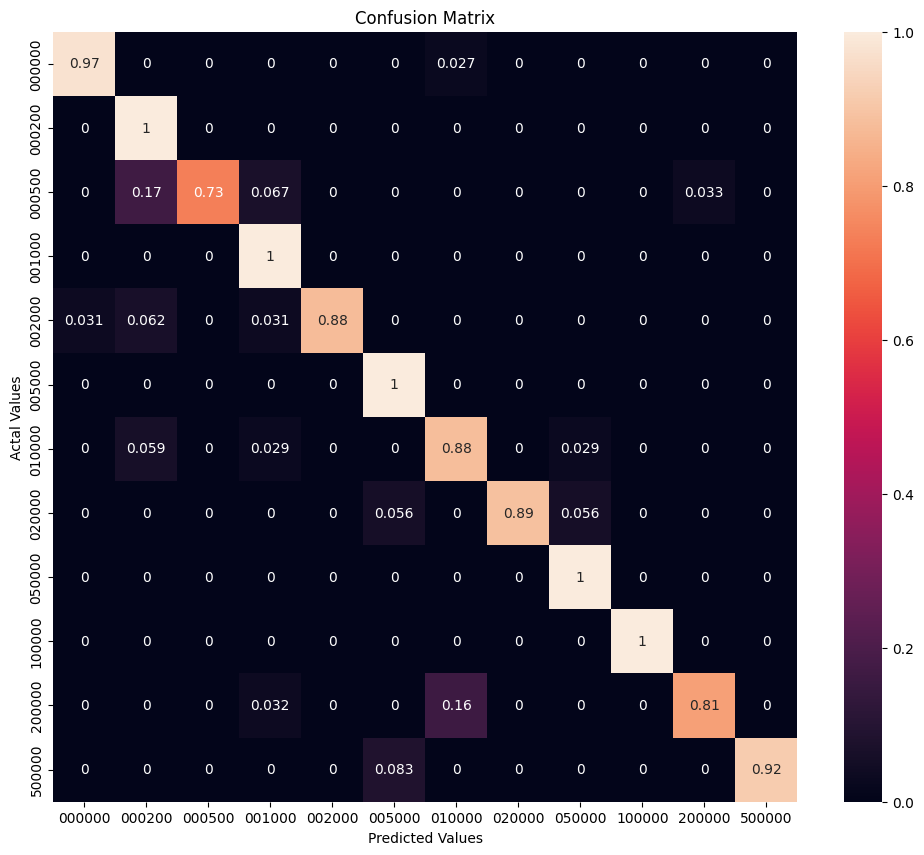

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_matrix = metrics.confusion_matrix(labels, preds, normalize="true")
cm_df = pd.DataFrame(
    confusion_matrix, index=categories.values(), columns=categories.values()
)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True)
plt.title("Confusion Matrix")
plt.ylabel("Actal Values")
plt.xlabel("Predicted Values")
plt.show()

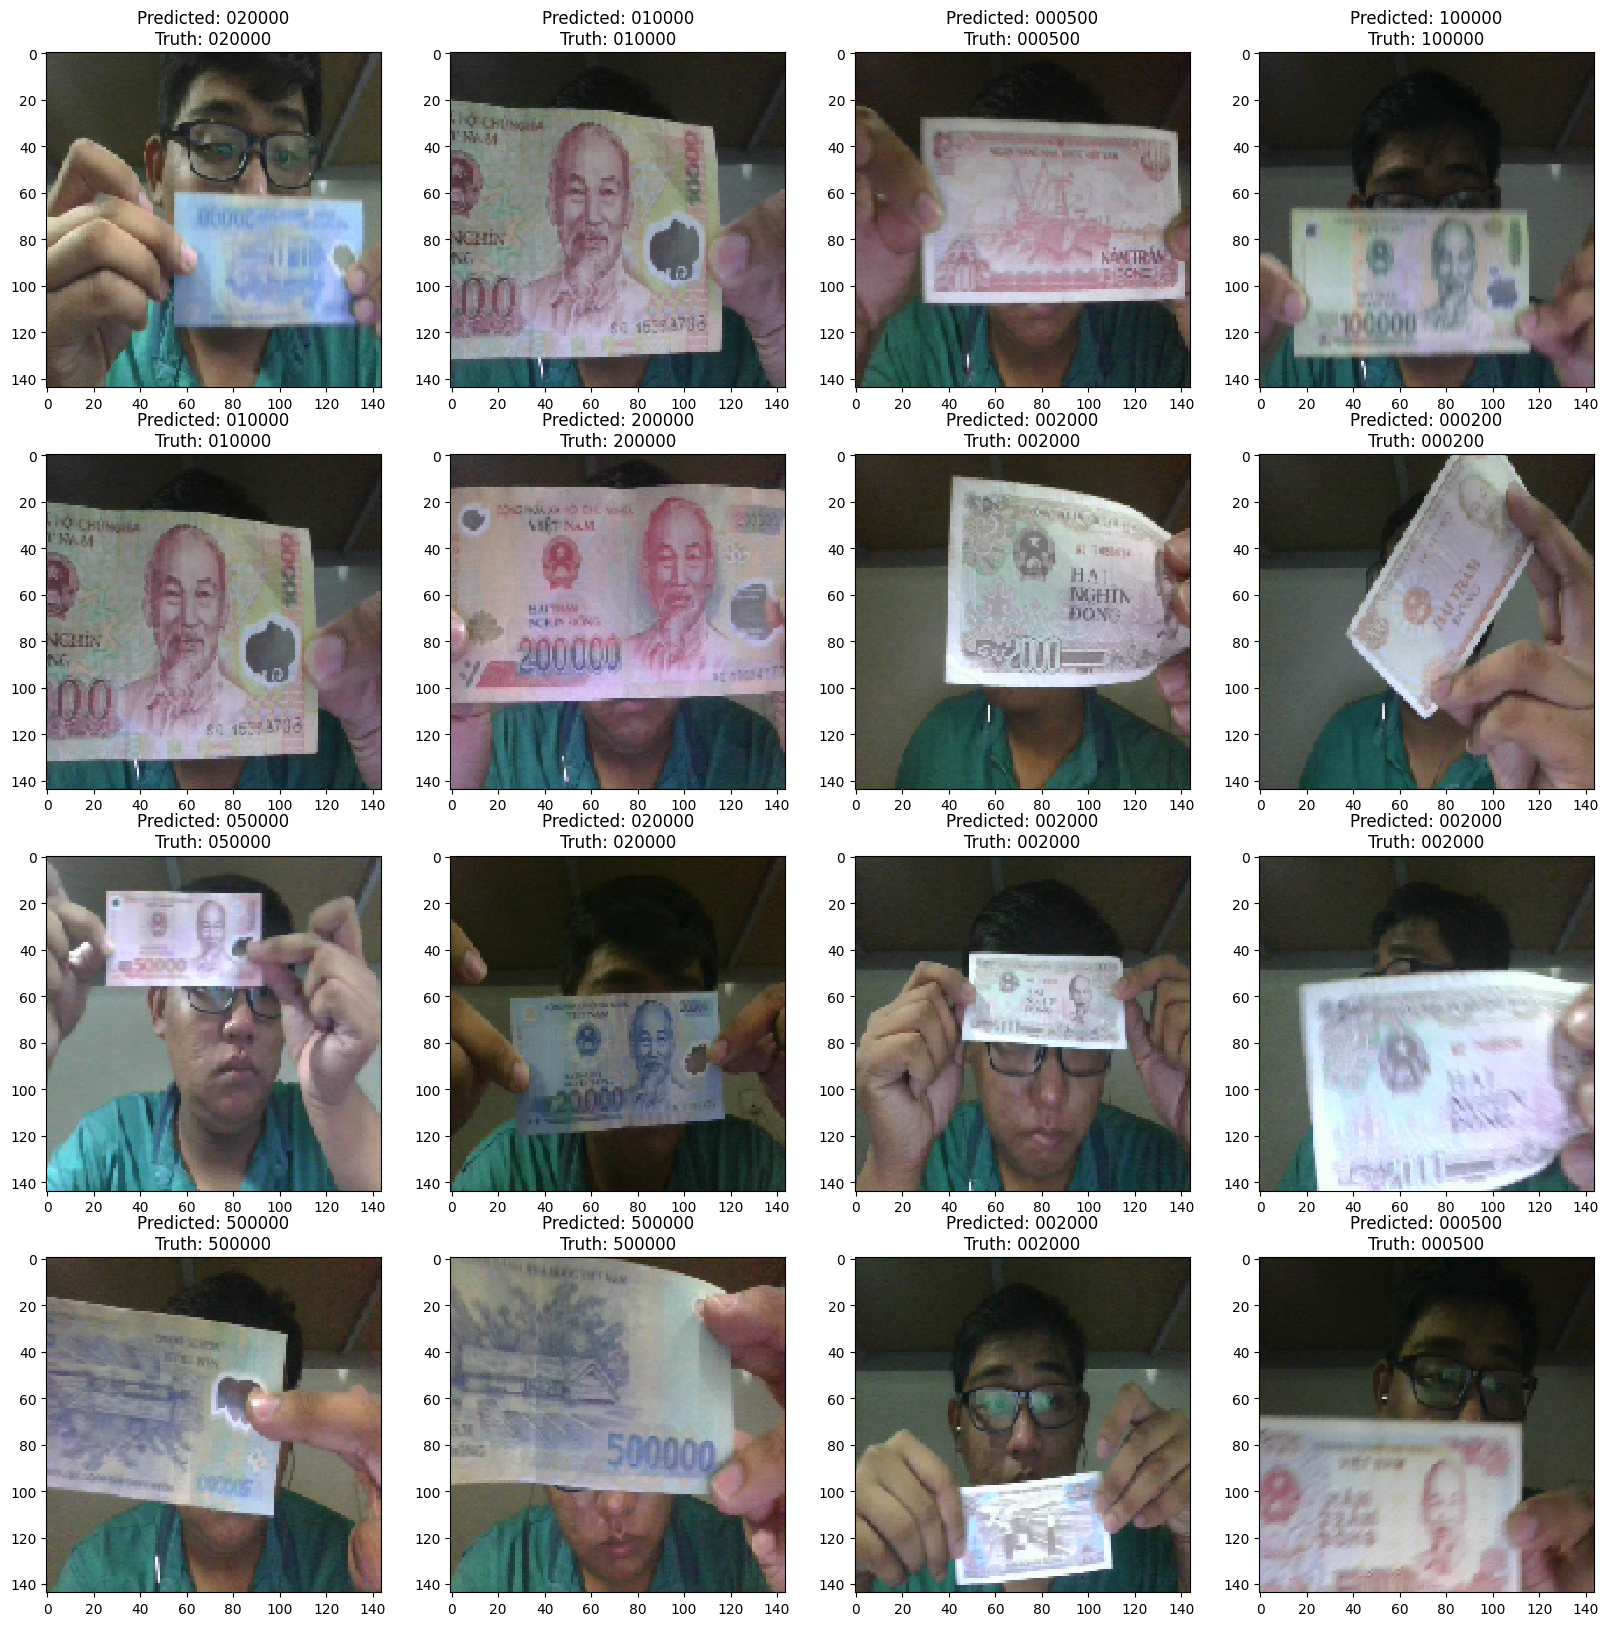

In [ ]:
fig = plt.figure(figsize=(20, 20))
for i in range(16):
    x = random.randint(0, total_test)
    fig.add_subplot(4, 4, i + 1)
    plt.title("Predicted: " + preds[x] + "\nTruth: " + labels[x])
    plt.imshow(test_generator[x][0][0] / 255, interpolation="nearest")
plt.show()